# On the Identification of Pulsar Stars

A DSCI 100 Project

Lucas Kuhn, Sophia Zhang, Michael Cheung

## Introduction

Out in the universe, astronomers have found many neutron stars. A subset of these stars fall under a rare classification known as a "pulsar", meaning that they produce a periodic radio signal that is detectable from Earth. These stars are of great interest, and so being able to identify them is a useful skill that furthers exploration efforts in understanding neutron stars.

In this project, we set out to develop a model for classifying them distinctly from those that are "non-pulsar". Our question to answer: "Are there characteristics of a pulsar candidate's curve profiles that serve as good predictors for pulsar and non-pulsar classification?".

To investigate this, we use the HTRU2 dataset provided by the UCI Machine Learning Repository. This dataset contains summary statistics for a large number of observed pulsar candidates as they exhibit on both the Integrated Pulse (folded) Profile as well as on the Dispersion Measure Signal-to-Noise Ratio (DM-SNR) curve, which is then associated alongside their known classifications as either "pulsar" or "non-pulsar".

## Methods

To carry out the investigation, we will train multiple K-Nearest Neighbours classifier models using various subsets of the columns in our dataset as predictor variables. Given how the candidates that are truly pulsar generally broadcast signal pulses that are "remarkably constant over long periods of time" (Kastergiou et. al, 2011), we can reasonably surmise that the summary statistics from candidates' curve profiles could serve as predictors for our classification model.

As a way of gaining insights as to which dataset columns to use in our set of predictor columns, we will first create scatter plots of pairs of the columns in a scatter plot matrix, colouring the points by their classification and inspecting for visible divisions. For example, columns that we may wish to exclude from the predictor variables are those that result in "heterogeneous" mixtures of the classified points with less defined independent groupings of points. This is a valid way to evaluate for predictors as plots provide an interface for human inspection, and are used to train other models such as artificial neural networks (Eatough et. al, 2010).

Using a GridSearchCV with 5-fold Cross-Validation, we can optimize the number of neighbours $k$. This allows us to efficiently test the validation accuracy at many values of $k$ and combat both overfitting and underfitting.

With our best model, we can assess its accuracy on the testing set using a confusion matrix, allowing us to more critically assess the accuracy based on whether false positives are more costly than false negatives.

## Results

We perform preliminary setup and retrieve the packages we expect to use.

In [1]:
# Retrieve relevant packages for dataframes and visualization tools
import pandas as pd
import altair as alt

# Retrieve relevant packages for classification and modelling
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

As the dataset we plan to import will contain more than 5000 observations, we will need to allow for greater data plotting.

In [2]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

The HTRU2 dataset can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/). We unzip the file to the `data/` directory and read the corresponding .CSV file into Jupyter Notebook.

In [3]:
pulsar_data = pd.read_csv(
    "../data/HTRU2/HTRU_2.csv",
    # .CSV file contains no column headers, we provide these here
    names=[
        "Profile_mean",
        "Profile_stdev",
        "Profile_skewness",
        "Profile_kurtosis",
        "DM_mean",
        "DM_stdev",
        "DM_skewness",
        "DM_kurtosis",
        "class"
    ]
)

pulsar_data.head().style.set_caption("Table 1.0: Head of the initial HTRU2 dataset")

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


At a high-level, we query for properties of the dataset's shape and columns.

In [4]:
pulsar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


From inspection of the first 5 rows, we can see that the dataset is already tidy, as it contains variables as columns, single candidates (observations) as rows, and each cell of the table containing a single numerical value. Furthermore, we note that the dataset contains 17,898 entries, and that there are no null values throughout, since all columns have the same number of non-null values.

The "class" column currently contains a simple integer value: 0 for non-pulsar, and 1 for pulsar. For ease of identification, we change these to string equivalents for easier interpretability.

In [5]:
# Note the call to `convert_dtypes()` method which changes the output of the second call to `info()` to a more suitable data type string
pulsar_data["class"] = pulsar_data["class"].replace({0: "non-pulsar", 1: "pulsar"}).convert_dtypes()
display(pulsar_data.info())

pulsar_data.head().style.set_caption("Table 1.1: Head of the HTRU2 dataset, with classes as String")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  string 
dtypes: float64(8), string(1)
memory usage: 1.2 MB


None

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,non-pulsar
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,non-pulsar
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,non-pulsar
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,non-pulsar
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,non-pulsar


Our training data should include non-pulsar and pulsar observations to best inform the model. Our testing data should follow the same idea to provide a fair test of accuracy of the model.

In [6]:
# Keep one other column outside the target classification column
pulsar_data_count = pulsar_data[["class", "Profile_mean"]].groupby("class").count().reset_index()

# Rename the column to more accurately reflect its purpose
pulsar_data_count = pulsar_data_count.rename(columns={"Profile_mean": "count"})
pulsar_data_count = pulsar_data_count.assign(pct=pulsar_data_count["count"] / len(pulsar_data))

pulsar_data_count.style.set_caption("Table 1.2: Distribution of the full HTRU2 dataset, by class")

,class,count,pct
0,non-pulsar,16259,0.908426
1,pulsar,1639,0.091574


We will base the proportions on what is found in the full version of the data. We will also arbitrarily use 75% of the data for training, and the remainder for testing.

In [7]:
pulsar_data_train, pulsar_data_test = train_test_split(
    pulsar_data, train_size=0.75, stratify=pulsar_data["class"], random_state=1234
)

pulsar_data_train_count = pulsar_data_train[["class", "Profile_mean"]].groupby("class").count().reset_index()
pulsar_data_train_count = pulsar_data_train_count.rename(columns={"Profile_mean": "count"})
pulsar_data_train_count = pulsar_data_train_count.assign(pct=pulsar_data_train_count["count"] / len(pulsar_data_train))

# We only evaluate the distribution of the testing set; we seek no further detail into the nature of the testing set past this
pulsar_data_test_count = pulsar_data_test[["class", "Profile_mean"]].groupby("class").count().reset_index()
pulsar_data_test_count = pulsar_data_test_count.rename(columns={"Profile_mean": "count"})
pulsar_data_test_count = pulsar_data_test_count.assign(pct=pulsar_data_test_count["count"] / len(pulsar_data_test))

In [8]:
pulsar_data_train_count.style.set_caption("Table 1.3: Class distribution of the training data")

,class,count,pct
0,non-pulsar,12194,0.908441
1,pulsar,1229,0.091559


In [9]:
pulsar_data_test_count.style.set_caption("Table 1.4: Class distribution of the testing data")

,class,count,pct
0,non-pulsar,4065,0.908380
1,pulsar,410,0.091620


The full dataset had a distribution of around 91% of the observations as "non-pulsar", and about 9% as "pulsar". The training and testing set are thus stratified to maintain this distribution.

Using our training data, we create our scatter plot matrix of all of our columns, so we can assess which variables may be good predictors.

In [10]:
pulsar_data_scatter_plot_matrix = (
    alt.Chart(pulsar_data_train)
    .mark_point(opacity=0.3)
    .encode(
        x=alt.X(alt.repeat("column"), type="quantitative"),
        y=alt.Y(alt.repeat("row"), type="quantitative"),
        color="class",
    )
    .properties(width=100, height=100)
    .repeat(
        row=[
            "Profile_mean", "Profile_stdev", "Profile_skewness", "Profile_kurtosis",
            "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis"
        ],
        column=[
            "DM_kurtosis", "DM_skewness", "DM_stdev", "DM_mean",
            "Profile_kurtosis", "Profile_skewness", "Profile_stdev", "Profile_mean"
        ]
    )
    .properties(title="Figure 1.0: Scatter plot matrix for HTRU2 dataset columns")
    .configure_title(fontSize=16)
)

pulsar_data_scatter_plot_matrix

alt.RepeatChart(...)

From this scatter plot matrix, we can see that our best predictors are likely those that consistently produce visible distinctions in the "non-pulsar" and "pulsar" classifications, with little to no "mixing" of categories.

With this as our definition, we suggest that our set of variables to use as predictors should contain:
- `Profile_mean`
- `Profile_skewness`
- `Profile_kurtosis`

We exclude the `Profile_stdev` as well as the statistics from the DM-SNR curve as they produce multiple plots with a significant mixing of points from both categories (e.g. plots within the lower-left section of the matrix).

With these 3 variables, we begin creating the pipelines for building our classifier models. As we are evaluating euclidean distances between points within a K-Nearest Neighbours model, and the predictors we intend to use have different value ranges (i.e. `Profile_mean` may have narrower/wider range than `Profile_skewness`), we will have to scale our values through preprocessing.

To build models using the different subset combinations of the predictor set, we will create multiple preprocessors along with the same number of pipelines.

In [11]:
# One predictor
mean_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_mean"]),
)

skewness_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_skewness"]),
)

kurtosis_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_kurtosis"]),   
)

# Two predictors
mean_skewness_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_mean", "Profile_skewness"]),
)

mean_kurtosis_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_mean", "Profile_kurtosis"]),
)

skewness_kurtosis_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_skewness", "Profile_kurtosis"]),
)

# All predictors
all_preprocessor = make_column_transformer(
    (StandardScaler(), ["Profile_mean", "Profile_skewness", "Profile_kurtosis"]),
)

Now that we have a preprocessor for each subset of the intended predictors, we can make their corresponding pipeline objects.

In [12]:
# One predictor
mean_pipe = make_pipeline(mean_preprocessor, KNeighborsClassifier())

skewness_pipe = make_pipeline(skewness_preprocessor, KNeighborsClassifier())

kurtosis_pipe = make_pipeline(kurtosis_preprocessor, KNeighborsClassifier())

# Two predictors
mean_skewness_pipe = make_pipeline(mean_skewness_preprocessor, KNeighborsClassifier())

mean_kurtosis_pipe = make_pipeline(mean_kurtosis_preprocessor, KNeighborsClassifier())

skewness_kurtosis_pipe = make_pipeline(skewness_kurtosis_preprocessor, KNeighborsClassifier())

# All predictors
all_pipe = make_pipeline(all_preprocessor, KNeighborsClassifier())

To determine an optimal hyperparameter $k$ to use as the number of neighbours in the KNN classifier model, we will run a `GridSearchCV` which will give us an idea of the best value. We will first set up the data that will be used to fit each run of `GridSearchCV`; the `X` and `y` data resulting from the preprocessors.

The preprocessors will already drop any columns not marked as part of the `StandardScaler()` by default; as such, we only need to ensure that `X` and `y` split up the training labels.

In [13]:
# Remove the target column from the training data to serve as X
X_train = pulsar_data_train.drop(columns=["class"])

# Isolate the target column in its own Series object
y_train = pulsar_data_train["class"]

With that, we can apply a `GridSearchCV` with each of the pipelines, fitting them to the `X_train` and `y_train` components. We will set up our search to investigate accuracies using a number of neighbours from 1 to 15. We will use a default 5-fold cross-validation.

Due to the size of the training set (13,423 rows before cross-validation), we will simplify our search to test on intervals of `25`, while increasing the number of neighbours to larger values. 

This also helps to reduce the reliance on a value of $k$ with maximum accuracy.

In [14]:
# Create parameter grid for number of neighbours to evaluate models on
param_grid = {
    # [1, 25, 50, 75, ..., 425, 450, 475, 500]
    "kneighborsclassifier__n_neighbors": [1] + [25*k for k in range(1, 21)],
}

In [15]:
# For each pipe, create a GridSearchCV and fit the data

# One predictor
mean_grid = GridSearchCV(
    estimator=mean_pipe,
    param_grid=param_grid,
    cv=5,
)
mean_model_grid = mean_grid.fit(X_train, y_train)


skewness_grid = GridSearchCV(
    estimator=skewness_pipe,
    param_grid=param_grid,
    cv=5,
)
skewness_model_grid = skewness_grid.fit(X_train, y_train)


kurtosis_grid = GridSearchCV(
    estimator=kurtosis_pipe,
    param_grid=param_grid,
    cv=5,
)
kurtosis_model_grid = kurtosis_grid.fit(X_train, y_train)


In [16]:
# Two predictors
mean_skewness_grid = GridSearchCV(
    estimator=mean_skewness_pipe,
    param_grid=param_grid,
    cv=5,
)
mean_skewness_model_grid = mean_skewness_grid.fit(X_train, y_train)


mean_kurtosis_grid = GridSearchCV(
    estimator=mean_kurtosis_pipe,
    param_grid=param_grid,
    cv=5,
)
mean_kurtosis_model_grid = mean_kurtosis_grid.fit(X_train, y_train)


skewness_kurtosis_grid = GridSearchCV(
    estimator=skewness_kurtosis_pipe,
    param_grid=param_grid,
    cv=5,
)
skewness_kurtosis_model_grid = skewness_kurtosis_grid.fit(X_train, y_train)

In [17]:
# All three predictors
all_grid = GridSearchCV(
    estimator=all_pipe,
    param_grid=param_grid,
    cv=5,
)
all_model_grid = all_grid.fit(X_train, y_train)

Next, we will extract the `cv_results_` attribute from the `GridSearch` executions.

In [52]:
accuracies_mean_grid = pd.DataFrame(mean_model_grid.cv_results_)

accuracies_skewness_grid = pd.DataFrame(skewness_model_grid.cv_results_)

accuracies_kurtosis_grid = pd.DataFrame(kurtosis_model_grid.cv_results_)

accuracies_mean_skewness_grid = pd.DataFrame(mean_skewness_model_grid.cv_results_)

accuracies_mean_kurtosis_grid = pd.DataFrame(mean_kurtosis_model_grid.cv_results_)

accuracies_skewness_kurtosis_grid = pd.DataFrame(skewness_kurtosis_model_grid.cv_results_)

accuracies_all_grid = pd.DataFrame(all_model_grid.cv_results_)

# As an example, we view the accuracies from the "all predictors" model
accuracies_all_grid.drop(columns=["mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time", "params"]).style.set_caption("Table 2.0: GridSearchCV fit statistics for varying k-neighbours")

,param_kneighborsclassifier__n_neighbors,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1,0.969460,0.968343,0.967970,0.967958,0.963487,0.967444,0.002053,21
1,25,0.978026,0.973557,0.984730,0.978763,0.976900,0.978395,0.003634,1
2,50,0.978026,0.972067,0.981750,0.979136,0.977645,0.977725,0.003172,2
3,75,0.977654,0.970950,0.982123,0.978763,0.976528,0.977203,0.003644,3
4,100,0.978026,0.970577,0.981750,0.978390,0.975782,0.976905,0.003694,4
5,125,0.977654,0.970577,0.982123,0.978018,0.975782,0.976831,0.003750,5
6,150,0.976909,0.970577,0.982123,0.977645,0.976155,0.976682,0.003691,6
7,175,0.976536,0.970205,0.981006,0.976528,0.976155,0.976086,0.003441,7
8,200,0.975791,0.969460,0.980633,0.975782,0.976155,0.975564,0.003561,8
9,225,0.974302,0.970205,0.980633,0.975410,0.976155,0.975341,0.003351,9


One at a time, we then determine the optimal $k$ value to use for each based on their Mean Test Scores. We will use a line plot to help visualize the trend in accuracy, and set a variable for the number of neighbours we choose.

The selection of $k$ will depend primarily on the highest accuracy. However, we also consider surrounding drops in accuracy as its performance under uncertainty.

In [19]:
accuracies_mean_grid_plot = (
    alt.Chart(accuracies_mean_grid, title="Figure 2.0: Grid Search using One Predictor (Profile_mean)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_mean_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.1: Top 5 k-values for One Predictor (Profile_mean)"))
accuracies_mean_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
9,225,0.966774
7,175,0.966774
6,150,0.966699
10,250,0.966699
4,100,0.966699


alt.Chart(...)

In [20]:
mean_model_best_k = 225

In [21]:
accuracies_skewness_grid_plot = (
    alt.Chart(accuracies_skewness_grid, title="Figure 2.1: Grid Search using One Predictor (Profile_skewness)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_skewness_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.2: Top 5 k-values for One Predictor (Profile_skewness)"))
accuracies_skewness_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
4,100,0.977352
5,125,0.977278
2,50,0.977129
3,75,0.977129
6,150,0.977129


alt.Chart(...)

In [22]:
skewness_model_best_k = 100

In [23]:
accuracies_kurtosis_grid_plot = (
    alt.Chart(accuracies_kurtosis_grid, title="Figure 2.2: Grid Search using One Predictor (Profile_kurtosis)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_kurtosis_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.3: Top 5 k-values for One Predictor (Profile_kurtosis)"))
accuracies_kurtosis_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
8,200,0.969381
9,225,0.969232
7,175,0.969232
2,50,0.969158
1,25,0.969083


alt.Chart(...)

In [24]:
kurtosis_model_best_k = 200

In [25]:
accuracies_mean_skewness_grid_plot = (
    alt.Chart(accuracies_mean_skewness_grid, title="Figure 2.3: Grid Search using Two Predictors (Profile_mean, Profile_skewness)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_mean_skewness_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.4: Top 5 k-values for Two Predictors (Profile_mean, Profile_skewness)"))
accuracies_mean_skewness_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
1,25,0.978619
2,50,0.978470
3,75,0.977725
4,100,0.977650
5,125,0.977278


alt.Chart(...)

In [26]:
mean_skewness_model_best_k = 50

In [27]:
accuracies_mean_kurtosis_grid_plot = (
    alt.Chart(accuracies_mean_kurtosis_grid, title="Figure 2.4: Grid Search using Two Predictors (Profile_mean, Profile_kurtosis)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_mean_kurtosis_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.5: Top 5 k-values for Two Predictors (Profile_mean, Profile_kurtosis)"))
accuracies_mean_kurtosis_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
2,50,0.970796
5,125,0.970648
1,25,0.970648
3,75,0.970648
4,100,0.970424


alt.Chart(...)

In [28]:
mean_kurtosis_model_best_k = 50

In [29]:
accuracies_skewness_kurtosis_grid_plot = (
    alt.Chart(accuracies_skewness_kurtosis_grid, title="Figure 2.5: Grid Search using Two Predictors (Profile_skewness, Profile_kurtosis)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_skewness_kurtosis_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.6: Top 5 k-values for Two Predictors (Profile_skewness, Profile_kurtosis)"))
accuracies_skewness_kurtosis_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
2,50,0.977874
3,75,0.977576
4,100,0.977352
1,25,0.977203
5,125,0.976831


alt.Chart(...)

In [30]:
skewness_kurtosis_model_best_k = 75

In [31]:
accuracies_all_grid_plot = (
    alt.Chart(accuracies_all_grid, title="Figure 2.6: Grid Search using Three Predictors (Profile_mean, Profile_skewness, Profile_kurtosis)")
    .mark_line(point=True)
    .encode(
        x=alt.X("param_kneighborsclassifier__n_neighbors", title="Number of Neighbors", scale=alt.Scale(zero=False),),
        y=alt.Y("mean_test_score", title="Mean Test Score", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .properties(width=400, height=400)
)

display(accuracies_all_grid.sort_values(by="rank_test_score")[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
        .head().style.set_caption("Table 2.7: Top 5 k-values for Three Predictors (Profile_mean, Profile_skewness, Profile_kurtosis)"))
accuracies_all_grid_plot

,param_kneighborsclassifier__n_neighbors,mean_test_score
1,25,0.978395
2,50,0.977725
3,75,0.977203
4,100,0.976905
5,125,0.976831


alt.Chart(...)

In [32]:
all_model_best_k = 75

We have set our chosen values of $k$ for each model. Now, we can fit our final version of each model and assess their predictions on the testing data. To do this, we replace the generic `KNeighborsClassifier` model in the respective pipelines, specifying the values of $k$ we have found.

In [33]:
mean_pipe = make_pipeline(mean_preprocessor, KNeighborsClassifier(n_neighbors=mean_model_best_k))

skewness_pipe = make_pipeline(skewness_preprocessor, KNeighborsClassifier(n_neighbors=skewness_model_best_k))

kurtosis_pipe = make_pipeline(kurtosis_preprocessor, KNeighborsClassifier(n_neighbors=kurtosis_model_best_k))

mean_skewness_pipe = make_pipeline(mean_skewness_preprocessor, KNeighborsClassifier(n_neighbors=mean_skewness_model_best_k))

mean_kurtosis_pipe = make_pipeline(mean_kurtosis_preprocessor, KNeighborsClassifier(n_neighbors=mean_kurtosis_model_best_k))

skewness_kurtosis_pipe = make_pipeline(skewness_kurtosis_preprocessor, KNeighborsClassifier(n_neighbors=skewness_kurtosis_model_best_k))

all_pipe = make_pipeline(all_preprocessor, KNeighborsClassifier(n_neighbors=all_model_best_k))

Using the previously prepared `X_train` and `y_train`, we fit the classifier models and prepare the testing data to use for predictions.

In [34]:
mean_fit = mean_pipe.fit(X_train, y_train)
skewness_fit = skewness_pipe.fit(X_train, y_train)
kurtosis_fit = kurtosis_pipe.fit(X_train, y_train)
mean_skewness_fit = mean_skewness_pipe.fit(X_train, y_train)
mean_kurtosis_fit = mean_kurtosis_pipe.fit(X_train, y_train)
skewness_kurtosis_fit = skewness_kurtosis_pipe.fit(X_train, y_train)
all_fit = all_pipe.fit(X_train, y_train)

# Isolate the components of the testing data, leaving the target column as the "y"
X_test = pulsar_data_test.drop(columns="class")
y_test = pulsar_data_test["class"]

Finally, the models predict on the testing data, and using the `score()` method we visualize the accuracy of each model.

In [35]:
models = [mean_fit, skewness_fit, kurtosis_fit, mean_skewness_fit, mean_kurtosis_fit, skewness_kurtosis_fit, all_fit]
model_names = ["mean_fit", "skewness_fit", "kurtosis_fit", "mean_skewness_fit", "mean_kurtosis_fit", "skewness_kurtosis_fit", "all_fit"]
scores = pd.DataFrame({"model_name": model_names, "score": [model.score(X_test, y_test) for model in models]}).sort_values(by="score", ascending=False).reset_index(drop=True)

display(scores.style.set_caption("Table 3.0: Accuracy Scores of Classifier models"))

scores_plot = (
    alt.Chart(scores, title="Figure 3.0: Accuracy Scores of Classifier models")
    .mark_line(point=True)
    .encode(
        x=alt.X("model_name", title="Model", sort=None), 
        y=alt.Y("score", title="Accuracy of Predictions", scale=alt.Scale(zero=False)),
    )
    .configure_axis(labelFontSize=16, titleFontSize=16)
    .configure_axisX(labelAngle=-45)
    .configure_title(fontSize=16)
    .properties(width=500)
)

scores_plot


,model_name,score
0,skewness_kurtosis_fit,0.978994
1,mean_skewness_fit,0.978771
2,skewness_fit,0.978547
3,all_fit,0.978324
4,kurtosis_fit,0.968492
5,mean_kurtosis_fit,0.968492
6,mean_fit,0.965587


alt.Chart(...)

To give additional detail, we will create a confusion matrix for each model such that we can assess the proportion of inaccuracies attributed to false positives and false negatives.

We take each model and append its predictions to the testing data. For illustrative purposes of examples where models predicted inaccurately, we take the `tail()` of the dataframe instead of the `head()`.

In [36]:
# Create a copy of the testing data, which will append the predictions of each model
model_conf_mat_df = pd.DataFrame(X_test)

# Recall the order of the models:
# 1. mean_fit
# 2. skewness_fit
# 3. kurtosis_fit
# 4. mean_skewness_fit
# 5. mean_kurtosis_fit
# 6. skewness_kurtosis_fit
# 7. all_fit

# Go through each of the models, and create a column containing its predictions on the testing data
for model_num in range(len(models)):
    model_conf_mat_df[model_names[model_num]] = models[model_num].predict(X_test)

# Add the actual classes for each observation
model_conf_mat_df["true_label"] = y_test

# Show the predictions, with just relevant columns
model_conf_mat_df.drop(columns=["Profile_stdev", "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis"]).tail(20).style.set_caption("Table 4.0: Last 20 Model predictions on Testing data with True labels")

,Profile_mean,Profile_skewness,Profile_kurtosis,mean_fit,skewness_fit,kurtosis_fit,mean_skewness_fit,mean_kurtosis_fit,skewness_kurtosis_fit,all_fit,true_label
15993,133.898438,-0.137995,-0.611754,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
7278,126.023438,-0.014760,-0.382703,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
6948,126.304688,0.126610,0.244634,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
14860,133.125000,0.037964,-0.266913,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
2985,118.781250,-0.023155,-0.288628,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
10099,112.171875,0.521913,0.761390,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
3034,95.781250,0.453032,0.247059,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
7675,96.687500,0.688369,2.509435,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,pulsar
892,120.750000,0.454148,0.597079,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar,non-pulsar
4615,32.132812,5.262150,35.735721,pulsar,pulsar,pulsar,pulsar,pulsar,pulsar,pulsar,pulsar


As our final step, we visualize all of the confusion matrices.

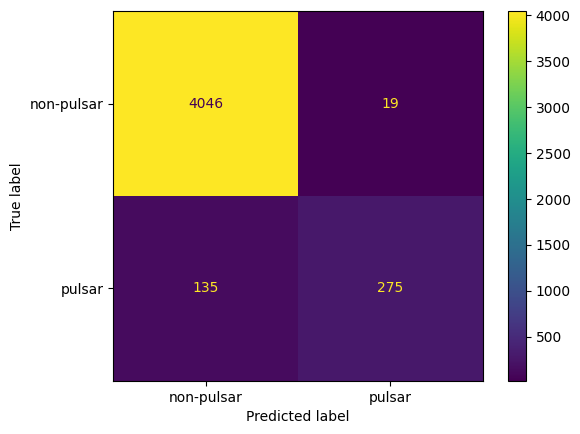

In [37]:
ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["mean_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

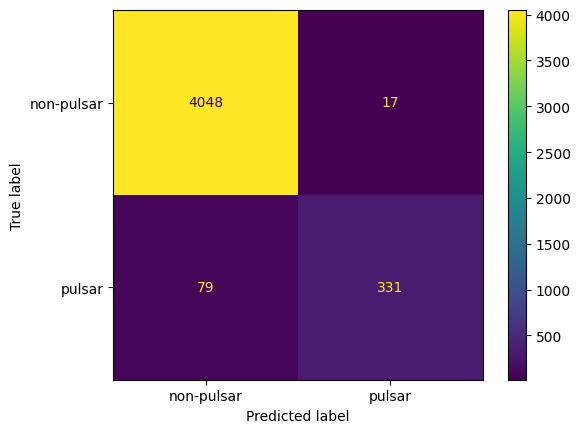

In [38]:
ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["skewness_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

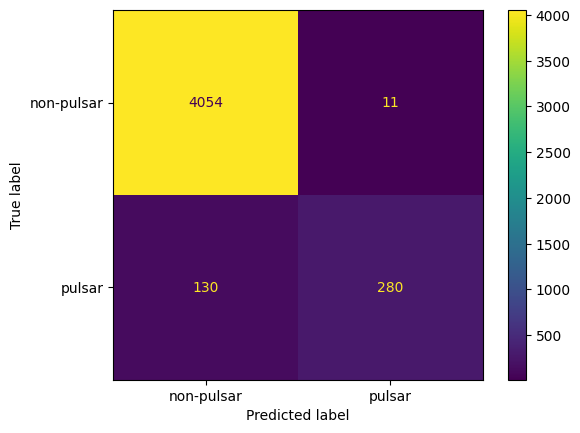

In [39]:
ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["kurtosis_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

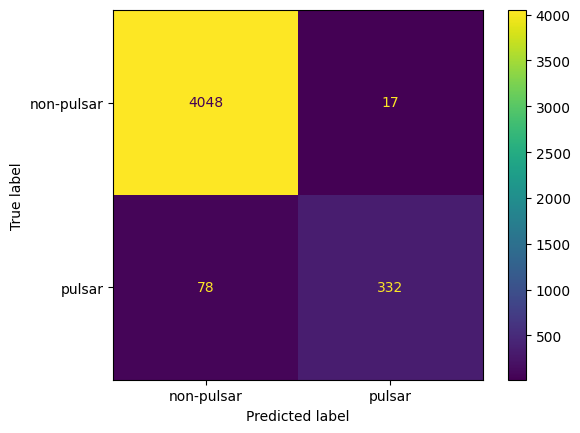

In [40]:
ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["mean_skewness_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

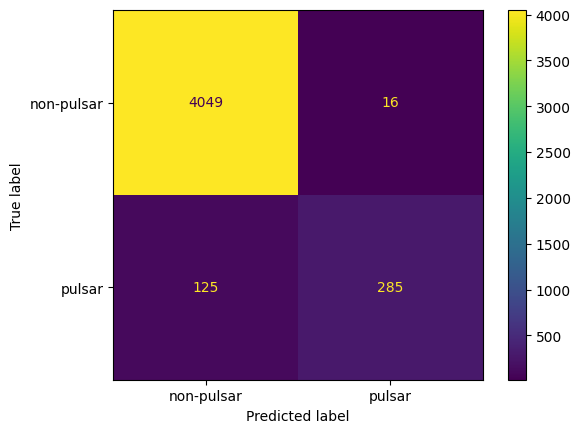

In [41]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["mean_kurtosis_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

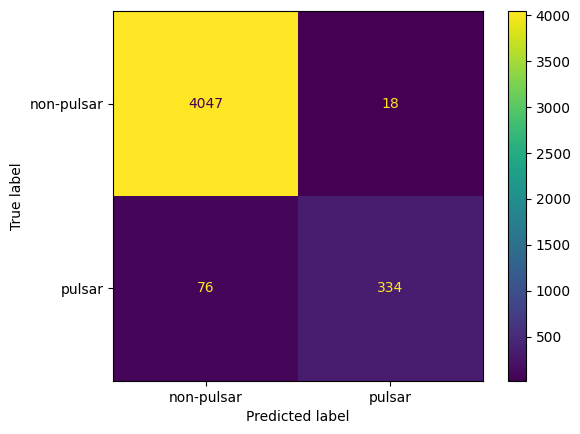

In [42]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["skewness_kurtosis_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

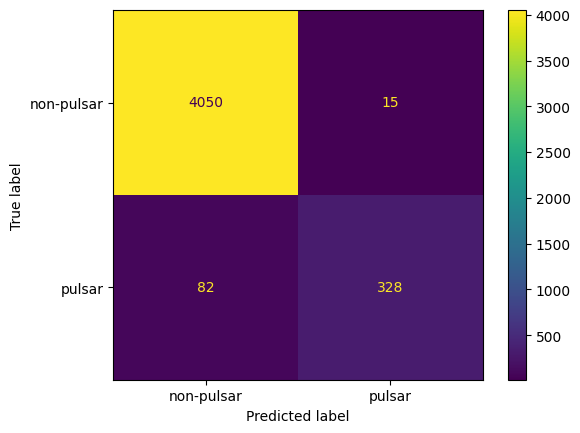

In [43]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=model_conf_mat_df["true_label"], y_pred=model_conf_mat_df["all_fit"], display_labels=mean_fit.classes_,
)

# TODO: add title

## Discussion

From our investigation, we found that in general the characteristics of a pulsar candidate on the Integrated Pulse (folded) Profile were effective classifiers -- namely the `Profile_mean`, `Profile_skewness`, and `Profile_kurtosis` -- as they displayed an inherent ability to distinguish and separate observations that were pulsar from those that were non-pulsar (as per Figure 1.0). While we initially expected to include attributes from the DM-SNR curve, these were disregarded as they resulted in several plots that mixed the two classes and appeared to make drawing a boundary more difficult.

Using various subsets of these columns as predictors, we found that the best combination with the highest accuracy for K-Nearest Neighbours classification was to use `Profile_skewness` and `Profile_kurtosis` (Figure 3.0). Based on the order of the single-predictor models according to their accuracies, it appears that order of importance for the three variables follows as: `Profile_skewness`, `Profile_kurtosis`, and `Profile_mean`; this is also reflected in how for example skewness with kurtosis performed better than skewness with mean. These findings could impact future research if it is taken that a candidate measured on the Integrated Pulse (folded) Profile serves as a more important indicator of its "pulsar" or "non-pulsar" nature.

Due to how we produce the confusion matrix for each models' predictions, we can also consider the impact of these findings with respect to false positives and false negatives. With a false positive, additional costs in resources and funding could be wasted in investigating a pulsar candidate deemed as "pulsar" when it is not. With a false negative, researchers may miss out on discovering a "pulsar" neutron star when the model deems it "non-pulsar". Which is more costly depends on whether the importance of discovering a "pulsar" neutron star exceeds the monetary funding that could potentially be wasted, or vice versa.

Our models generally had a greater number of false negatives than false positives.

While we do not specifically detail the ranges of values that the chosen variables should fall in order to mark a candidate as "pulsar" or "non-pulsar", this can be extended to visualize the boundary drawn by the K-Nearest Neighbours classifier models in future work.

As the HTRU2 dataset is based on summary curve statistics (mean, standard deviation, skewness, kurtosis) of multiple signal pulses taken from a candidate, a future question may be to ask whether there is a way to classify single pulses as indicative of a pulsar neutron star, allowing for even more efficient identification.

## References

1. Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443-2450.

2. Karastergiou, A., Roberts, S. J., Johnston, S., Lee, H. J., Weltevrede, P., & Kramer, M. (2011). A transient component in the pulse profile of PSR J0738− 4042. Monthly Notices of the Royal Astronomical Society, 415(1), 251-256.